<a href="https://colab.research.google.com/github/Reema-Almadhi/heart-disease-prediction/blob/main/Heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [469]:
# loading the Data

# update path below to your own path
df = pd.read_csv('/content/drive/MyDrive/Heart-disease/heart.csv')

# rename target column to match original code usage
df = df.rename(columns={'target': 'disease_present'})

df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_present
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [470]:
# checking for missing values

missing = df.isnull().sum()

if missing.sum() > 0:
    plt.figure(figsize=(8,6))
    missing[missing > 0].sort_values().plot(kind='barh')
    plt.title("Missing Values per Feature")
    plt.show()

**Visuals**

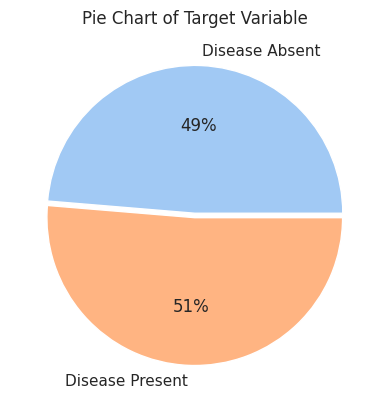

In [471]:

# Pie-chart of Target feature

unique_values = df['disease_present'].unique()
counts = df['disease_present'].value_counts().sort_values()
percentages = counts / counts.sum() * 100
plt.pie(percentages, labels=['Disease Absent', 'Disease Present'],
        colors=sns.color_palette('pastel'), explode=[0.02,0.01], autopct='%.0f%%')
plt.title('Pie Chart of Target Variable')
plt.show()

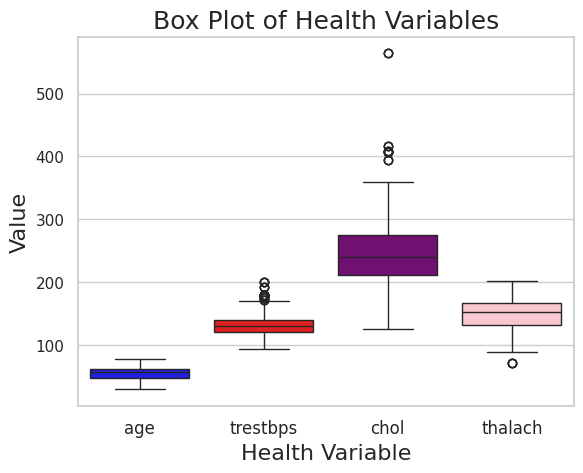

In [472]:
# Box Plot of Health Variables

health_variables = ['age', 'trestbps', 'chol', 'thalach']
colors = ['blue', 'red', 'purple', 'pink']
sns.set(style="whitegrid")
ax = sns.boxplot(data=df[health_variables], palette=colors)
ax.set_xticks(range(len(health_variables)))
ax.set_xticklabels(health_variables, fontsize=12)
ax.set_xlabel('Health Variable', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.set_title('Box Plot of Health Variables', fontsize=18)
plt.show()

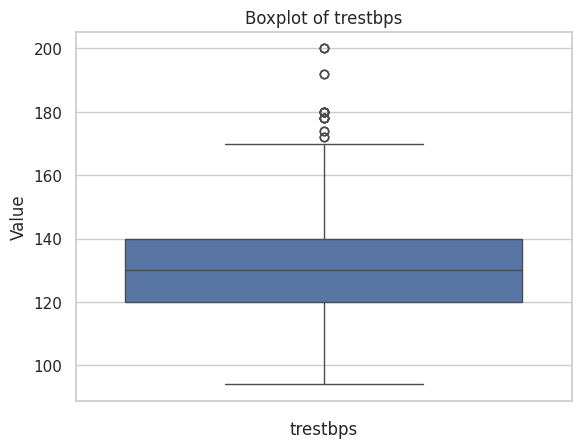

In [473]:
# Boxplot for any numerical feature
numerical_features = ['age', 'trestbps', 'chol', 'fbs', 'exang', 'oldpeak', 'thalach']
feature = 'trestbps'
sns.boxplot(y=df[feature])
plt.xlabel(feature)
plt.ylabel('Value')
plt.title(f'Boxplot of {feature}')
plt.show()

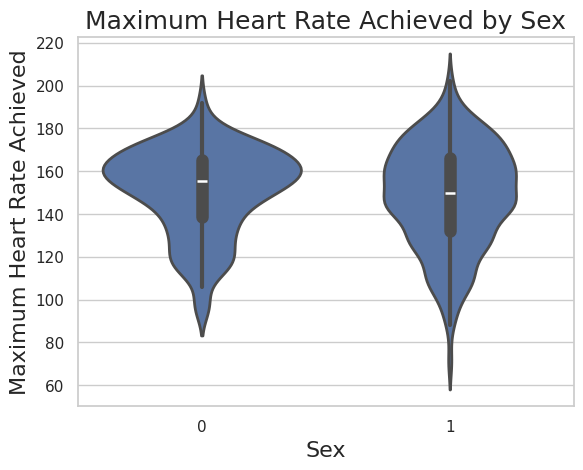

In [474]:
# Violin Plot of Maximum Heart Rate Achieved

sns.set(style="whitegrid")
ax = sns.violinplot(x=df["sex"], y=df["thalach"], linewidth=2)
ax.set_xlabel('Sex', fontsize=16)
ax.set_ylabel('Maximum Heart Rate Achieved', fontsize=16)
ax.set_title('Maximum Heart Rate Achieved by Sex', fontsize=18)
plt.show()

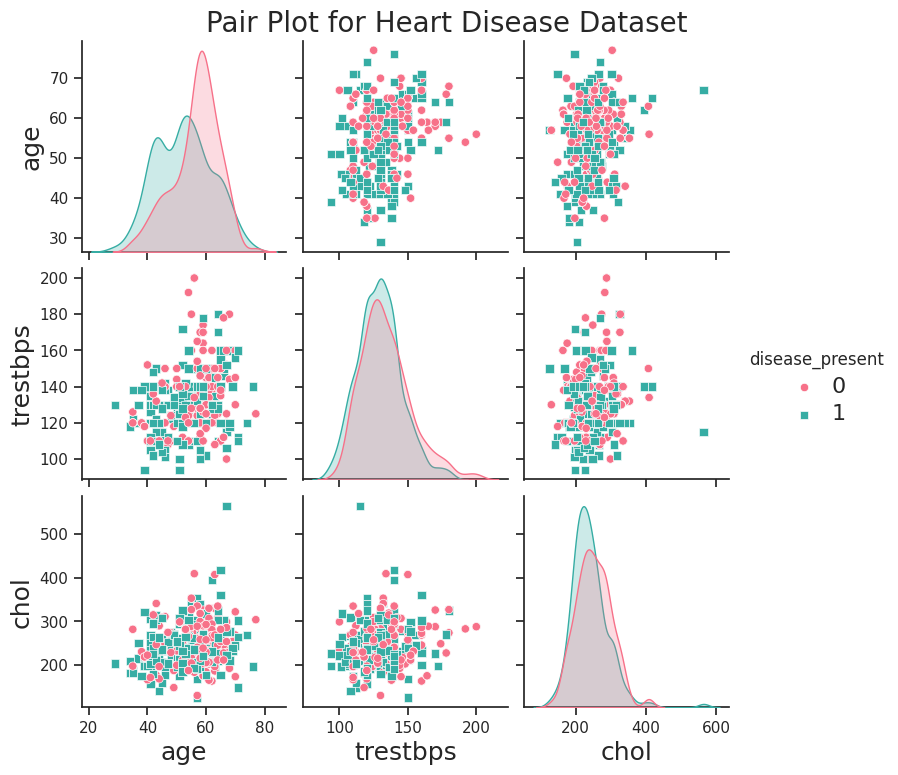

In [475]:
# Pair Plot

selected_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'disease_present']
df_subset = df[selected_columns].copy()

# Convert categorical variables
df_subset['sex'] = df_subset['sex'].astype('category')
df_subset['cp'] = df_subset['cp'].astype('category')
df_subset['disease_present'] = df_subset['disease_present'].astype('category')

sns.set(style="ticks", color_codes=True)
pair_plot = sns.pairplot(df_subset, hue='disease_present', palette='husl', markers=["o", "s"])
pair_plot.fig.suptitle("Pair Plot for Heart Disease Dataset", y=1.02, fontsize=20)

legend = pair_plot._legend
for text in legend.get_texts():
    text.set_fontsize(16)

for ax in pair_plot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.show()



In [476]:
# Data Transformation for Modeling

label_encoder = LabelEncoder()
for col in ['cp', 'restecg', 'slope', 'thal', 'fbs', 'exang']:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])

# 'sex' is already numeric (0/1), so keep as-is
df.to_csv('/content/drive/MyDrive/final_data.csv', index=False)


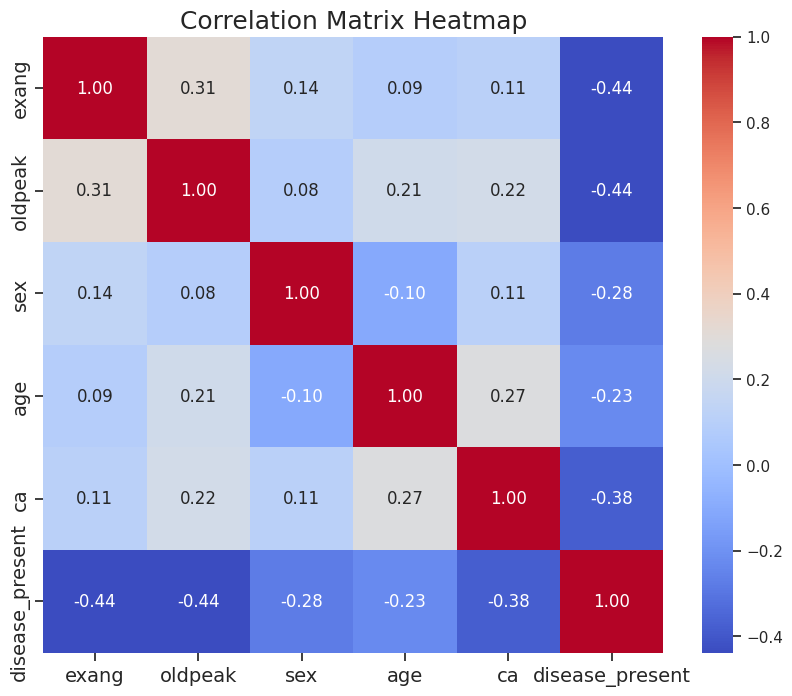

In [477]:
# Correlation Matrix Heatmap
features_analysis=['exang', 'oldpeak', 'sex', 'age', 'ca', 'disease_present']

df[i] = pd.to_numeric(df[i], errors='coerce')

subset_data = df[features_analysis]

correlation_matrix = subset_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Classification Models**

In [478]:
# Scaling the data using standard scaler

# Load preprocessed data (label encoded version saved during preprocessing)
df = pd.read_csv('/content/drive/MyDrive/final_data.csv')

X = df.iloc[:, :-1].values # Features
y = df.iloc[:, -1].values # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) #80/20 split - fixed seed for reproducibility

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)




Training Accuracy (SVM): 94.88%
Test Accuracy (SVM): 96.59%

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        98
           1       0.95      0.99      0.97       107

    accuracy                           0.97       205
   macro avg       0.97      0.96      0.97       205
weighted avg       0.97      0.97      0.97       205


Cross-Validation Scores: [0.93902439 0.90853659 0.84146341 0.91463415 0.90243902]
Mean CV Accuracy: 90.12%
CV Std Dev: 0.0324


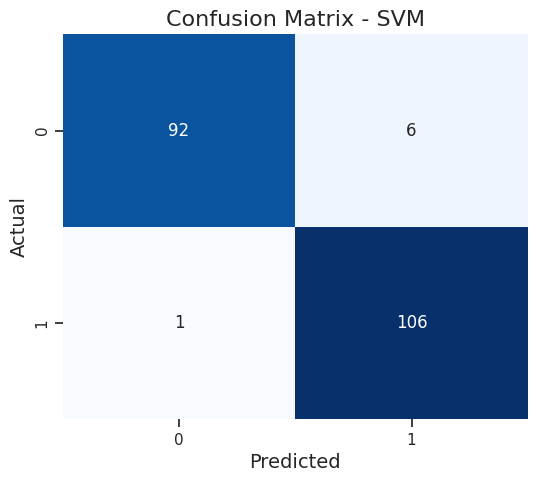

In [479]:
# SVM

# Initialize model
svm = SVC(kernel='rbf', random_state=0)

# Train model
svm.fit(X_train, y_train)

# Predictions
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy (SVM): {train_accuracy:.2%}")
print(f"Test Accuracy (SVM): {test_accuracy:.2%}")

# Classification report
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred_test))

# Cross-validation
cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2%}")
print(f"CV Std Dev: {cv_scores.std():.4f}")

# Plot confusion matrix (Test Set)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Store for comparison
svm_accuracy = test_accuracy * 100
svm_precision = precision_score(y_test, y_pred_test) * 100
svm_recall = recall_score(y_test, y_pred_test) * 100
svm_f1 = f1_score(y_test, y_pred_test) * 100


Training Accuracy: 85.85%
Test Accuracy: 86.34%

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        98
           1       0.83      0.93      0.88       107

    accuracy                           0.86       205
   macro avg       0.87      0.86      0.86       205
weighted avg       0.87      0.86      0.86       205


Cross-Validation Scores: [0.87804878 0.87195122 0.79878049 0.8902439  0.79878049]
Mean CV Accuracy: 84.76% 
CV Std Dev: 0.0403 



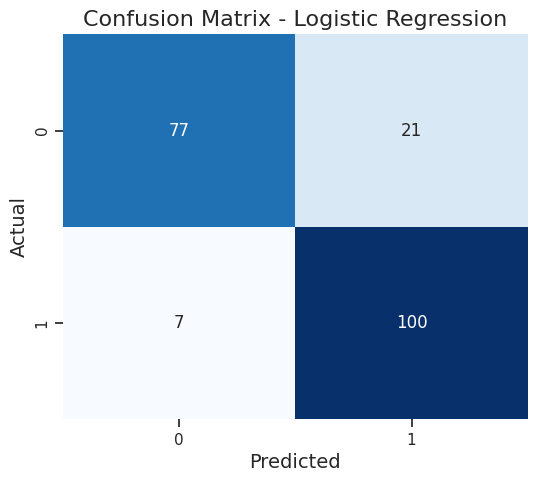

In [480]:
# Logistic Regression


# Train model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))

# Cross-validation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2%} ")
print(f"CV Std Dev: {cv_scores.std():.4f} \n")

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Store for comparison
lr_accuracy = test_accuracy * 100
lr_precision = precision_score(y_test, y_pred_test) * 100
lr_recall = recall_score(y_test, y_pred_test) * 100
lr_f1 = f1_score(y_test, y_pred_test) * 100


Training Accuracy (XGBoost): 89.02%
Test Accuracy (XGBoost): 89.76%

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        98
           1       0.88      0.93      0.90       107

    accuracy                           0.90       205
   macro avg       0.90      0.90      0.90       205
weighted avg       0.90      0.90      0.90       205


Cross-Validation Scores: [0.88414634 0.87804878 0.8597561  0.90243902 0.82926829]
Mean CV Accuracy: 87.07%
CV Std Dev: 0.0248 



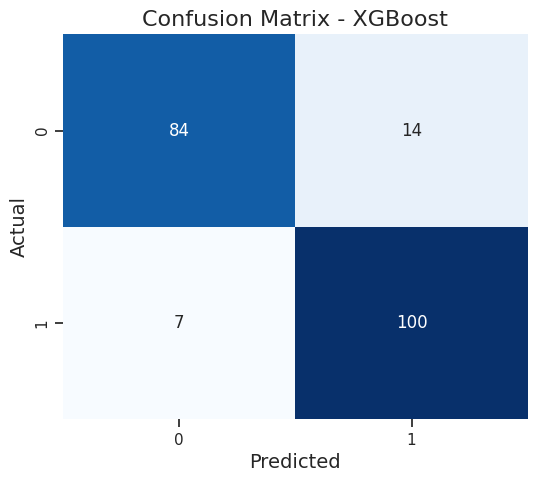

In [481]:
#XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Initialize model
xg = XGBClassifier(
    n_estimators=50, # reduced to prevent overfitting
    max_depth=2,
    learning_rate=0.1,
    random_state=0 )


# Train model
xg.fit(X_train, y_train)

# Predictions
y_pred_train = xg.predict(X_train)
y_pred_test = xg.predict(X_test)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy (XGBoost): {train_accuracy:.2%}")
print(f"Test Accuracy (XGBoost): {test_accuracy:.2%}")

# Classification report
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred_test))

# Cross-validation
cv_scores = cross_val_score(xg, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2%}")
print(f"CV Std Dev: {cv_scores.std():.4f} \n")

# Plot confusion matrix (Test Set)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Store accuracy for comparison
xgb_accuracy = test_accuracy * 100
xgb_precision = precision_score(y_test, y_pred_test) * 100
xgb_recall = recall_score(y_test, y_pred_test) * 100
xgb_f1 = f1_score(y_test, y_pred_test) * 100



Training Accuracy (KNN): 95.85%
Test Accuracy (KNN): 88.29%

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        98
           1       0.87      0.91      0.89       107

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205


Cross-Validation Scores: [0.86585366 0.84146341 0.80487805 0.88414634 0.81707317]
Mean CV Accuracy: 84.27%
CV Std Dev: 0.0295 



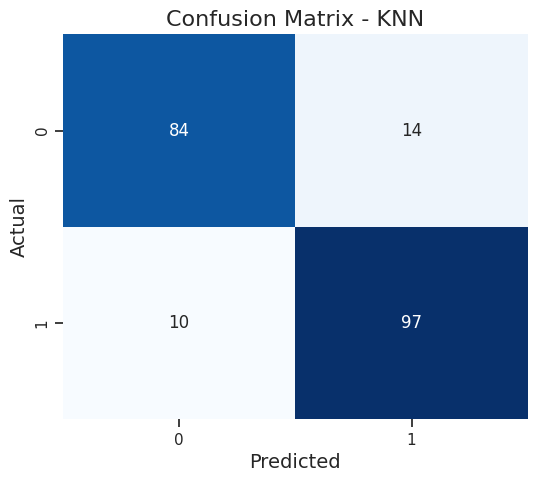

In [482]:
# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
# Initialize model
knn = KNeighborsClassifier(n_neighbors=5)

# Train model
knn.fit(X_train, y_train)

# Predictions
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy (KNN): {train_accuracy:.2%}")
print(f"Test Accuracy (KNN): {test_accuracy:.2%}")

# Classification report
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred_test))

# Cross-validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2%}")
print(f"CV Std Dev: {cv_scores.std():.4f} \n")

# Plot confusion matrix (Test Set)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - KNN', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Store accuracy for comparison
knn_accuracy = test_accuracy * 100
knn_precision = precision_score(y_test, y_pred_test) * 100
knn_recall = recall_score(y_test, y_pred_test) * 100
knn_f1 = f1_score(y_test, y_pred_test) * 100


Training Accuracy (Random Forest): 84.02%
Test Accuracy (Random Forest): 86.83%

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        98
           1       0.86      0.89      0.88       107

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205


Cross-Validation Scores: [0.87804878 0.87195122 0.81097561 0.8902439  0.80487805]
Mean CV Accuracy: 85.12%
CV Std Dev: 0.0359 



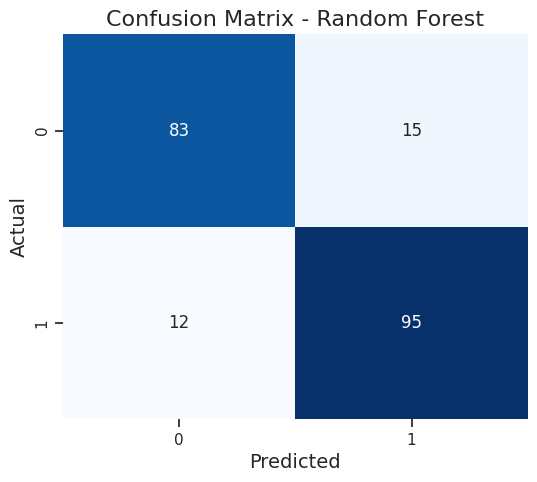

In [483]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    random_state=0
)

# Train model
rf.fit(X_train, y_train)

# Predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy (Random Forest): {train_accuracy:.2%}")
print(f"Test Accuracy (Random Forest): {test_accuracy:.2%}")

# Classification report
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred_test))

# Cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.2%}")
print(f"CV Std Dev: {cv_scores.std():.4f} \n")

# Plot confusion matrix (Test Set)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Store accuracy for comparison
rf_accuracy = test_accuracy * 100
rf_precision = precision_score(y_test, y_pred_test) * 100
rf_recall = recall_score(y_test, y_pred_test) * 100
rf_f1 = f1_score(y_test, y_pred_test) * 100

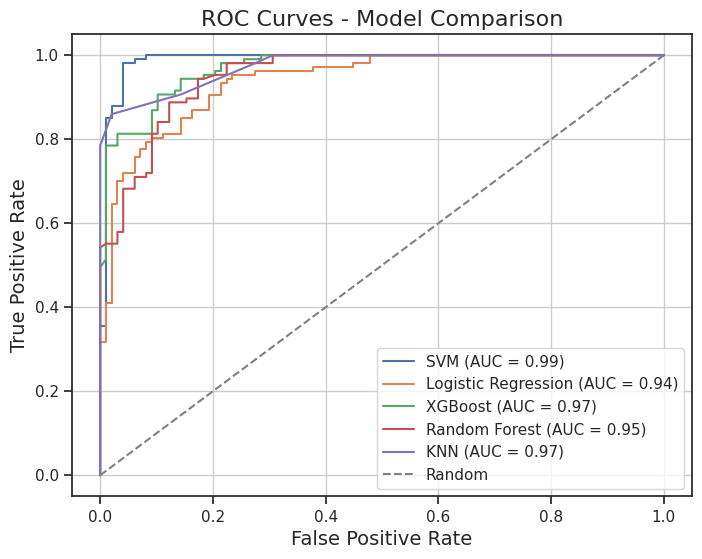

In [493]:
# ROC Curves - All Models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# SVM
fpr, tpr, _ = roc_curve(y_test, svm.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')

# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')

# XGBoost
fpr, tpr, _ = roc_curve(y_test, xg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')

# KNN
fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')

# Random baseline
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves - Model Comparison', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

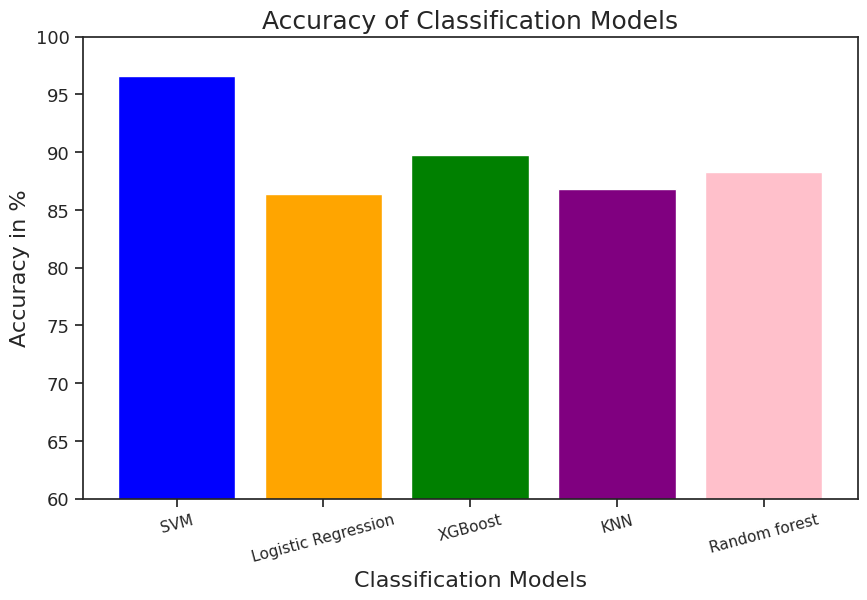

In [485]:
# Visualizations comparing Classification Models

# Accuracy scores of three models
models = ['SVM', 'Logistic Regression', 'XGBoost','KNN', 'Random forest']
accuracy = [svm_accuracy, lr_accuracy, xgb_accuracy, rf_accuracy, knn_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green', 'purple', 'pink'])
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Accuracy in %', fontsize=16)
plt.title('Accuracy of Classification Models', fontsize=18)
plt.xticks(fontsize=11, rotation=15)
plt.yticks(fontsize=13)
plt.ylim(60, 100)  # lowered from 70 since KNN might be below 70
plt.show()


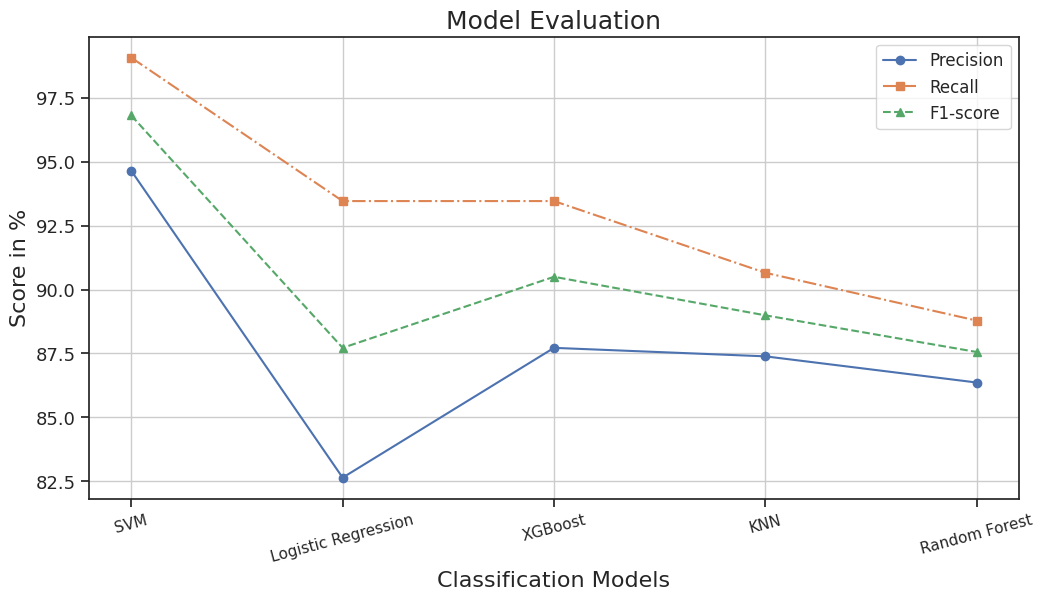

In [486]:
# Line chart to compare precision, recall and f1-score of classifiers

# Precision, recall, and F1-scores of three models
models = ['SVM', 'Logistic Regression', 'XGBoost', 'KNN', 'Random Forest']
precision = [svm_precision, lr_precision, xgb_precision, knn_precision, rf_precision]
recall = [svm_recall, lr_recall, xgb_recall, knn_recall, rf_recall]
f1_scores = [svm_f1, lr_f1, xgb_f1, knn_f1, rf_f1]

plt.figure(figsize=(12, 6))
plt.plot(models, precision, marker='o', label='Precision', linestyle='-')
plt.plot(models, recall, marker='s', label='Recall', linestyle='-.')
plt.plot(models, f1_scores, marker='^', label='F1-score', linestyle='--')
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Score in %', fontsize=16)
plt.title('Model Evaluation', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=11, rotation=15)
plt.yticks(fontsize=13)
plt.grid(True)
plt.show()



In [492]:
print ('svm')
print ('precision',svm_precision)
print('accuracy' , svm_accuracy)
print ('f1', svm_f1)
print ('recall', svm_recall)


print ('\n KNN')
print ('precision' ,knn_precision)
print('accuracy' ,knn_accuracy)
print ('f1', knn_f1)
print ('recall',knn_recall)


print ('\n random forest')
print ('precision', rf_precision)
print('accuracy',rf_accuracy)
print ('f1', rf_f1)
print ('recall', rf_recall)


print ('\n logistic regression')
print ('precision', lr_precision)
print('accuracy',lr_accuracy)
print ('f1', lr_f1)
print ('recall', lr_recall)



print ('\n XGBoost')
print ('precision', xgb_precision)
print('accuracy',xgb_accuracy)
print ('f1', xgb_f1)
print ('recall', xgb_recall)




svm
precision 94.64285714285714
accuracy 96.58536585365853
f1 96.80365296803653
recall 99.06542056074767

 KNN
precision 87.38738738738738
accuracy 88.29268292682927
f1 88.9908256880734
recall 90.65420560747664

 random forest
precision 86.36363636363636
accuracy 86.82926829268293
f1 87.55760368663594
recall 88.78504672897196

 logistic regression
precision 82.64462809917356
accuracy 86.34146341463415
f1 87.71929824561403
recall 93.45794392523365

 XGBoost
precision 87.71929824561403
accuracy 89.75609756097562
f1 90.49773755656109
recall 93.45794392523365
